# Plots Comparing Numeric Integration Algorithms

There are six methods available in the ode_int function. We will explore each. Some work better than others for this particluar case.

## Setup
The code below calls libraries for use in this notebook

In [66]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

#######################
### import packages 
#######################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import pickle




## Set Parameters

In [30]:
############################################
### Parameters and experimental conditions
############################################

k1 = 1E7          ### Values for kinetic parameters
k_1 = 1E5
kcat = 1E3

E_conc = 1E-6     ### Experimenatal condition
S_conc = 0.1
      
time_end = 200   ### The end time - had to make slightly longer than experimental time to capture last point
n_points = 1200   ### number of points - increase if needed

#########################################
### Create series of time points      
#########################################

t_line = np.linspace(0, time_end, n_points) ### time vector (list of time points)

#########################################
### Report the Michaelis-Menten parameters      
#########################################

KM_model = (k_1 + kcat)/k1         ### Calculate Briggs-Haldane Km value

print(f"Km: {KM_model*1000:0.2f} mM")    ### Print out calculated MM parameters
print(f"Vmax: {kcat*E_conc*1E6*60:0.2f} uM min")
print(f"kcat/Km: {kcat/KM_model:0.2e}")

Km: 10.10 mM
Vmax: 60000.00 uM min
kcat/Km: 9.90e+04


## Analytical Integration of the MM equation

The code below determines the close-form integration of the MM equation and creates a function, f, that uses this integrated equation.

Then the function is used to calculate substrate concentration at given time points using the parameters established above.

In [31]:
##########################
### Set up symbolic equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                            ### display the equation used to create the S vs. t data              

##############################################################################

##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax

##########################
### Set up parameters
##########################

Vmax = E_conc * kcat

##########################
### calculate x and y data
##########################
                                                ### time comes from the first code block above
s = f(t_line, S_conc, KM_model, Vmax)           ### Calculate substrate conc according to the function
s = np.real(s)                                  ### the Lambert function produces imaginary numbers. Use on the real component



The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

## Numerical Integration of a System of OD Equations

The code below will establish the MM model as a set of ordinary differential equations. Then it will use solve_ivp to solve the integrated equation using numerical methods. An object, int, is returned. It contains all the given time points and calculated values for [S]. These values will differ slightly from true values because of the way numerical methods work. But how much error is there?

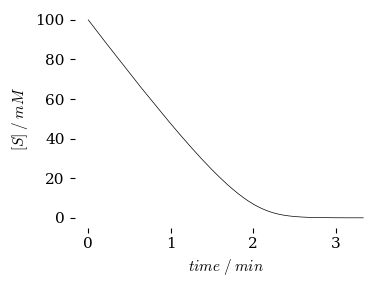

In [77]:
############################################
### Create a function that describes the 
### system of differential equations. 
############################################

def rates(t, c, K1, K_1, Kcat):  

    S = c[0]; E = c[1]; ES = c[2]           ### assign initial conc. from input list c

    ds_dt = -K1 * c[0] * c[1] + K_1 * c[2]    ### rates of each reaction step with give concentration in list c
    de_dt = -K1 * c[0] * c[1] + K_1 * c[2] + Kcat * c[2]
    des_dt = K1 * c[0] * c[1] - K_1 * c[2] - Kcat * c[2]
    dp_dt =  Kcat * c[2]

    return [ds_dt, de_dt, des_dt, dp_dt]

#########################################
### Integrate the system of differential equations      
#########################################

initial = [S_conc, E_conc, 0, 0]      ### Set list of initial values (S, E, ES, P)

method2 = 'RK45'      ### 'LSODA', 'Radau', 'BDF'
                        ### load picked results for previous runs with 'RK45', 'RK23','DOP853' - they take a looong time
 
int = solve_ivp(rates,                ### the function being integrated. 
                [0, time_end],        ### start and endpoint of integration
                initial,              ### initial values
                method = method2,     ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                t_eval = t_line,      ### time points at which to calculate values
#                t_eval = time_exp,      ### time points at which to calculate values
                first_step = 1e-7,    ### take a very small first step. the initial rate is much faster than the average slope.
                args = [k1,k_1,kcat]  ### values to send to function after t and c
                )

#########################################
### Save int object using pickle      
#########################################

# Pickle the object int
with open("int_object_"+method2+"_timefrom_tline.pkl", "wb") as f:
    pickle.dump(int, f)  

#########################################
### Extract the results from the returned data object      
#########################################

time = int.t        ### solve_inp() returns an array for time indexed as 't'
yarray = int.y      ### Also retruns and array of calculated y values.
                    ###  if more than one value returned from function we will
                    ###  get a array of arrays for each value
yarray = yarray[0]  ### The first array in the y-array is for S: substrate

##################################################################################
### Plot the results
##################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  

                    ### set x and y values for plot code below
x = time/60         ### convert time from seconds to minutes
y = yarray*1000     ### convert conc from M to mM

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

#########################################
### Add more style
#########################################
        
ax.set(ylabel=r"$[S]\;/\;mM $", 
        xlabel=r"$time\; /\; min$",
#        title = "Conc. vs time",
        xlim=[None, None],      
        ylim=[None, None])


fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig("plot.pdf")    # use this to save the figure in PDF format
plt.show()                 # output the combined four plots



## Difference Plots

We now have a two sets of concentrations: *s* calculated at a set of time points using the analytical integrated equation for the MM eqn; and *yarray* calculated using numerical methods at the same time points.

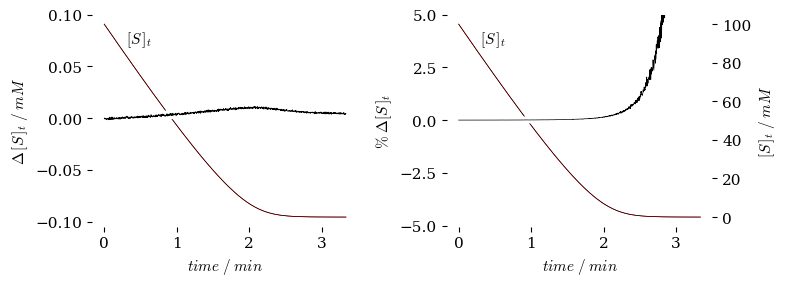

In [78]:


##########################
### calculate x and y data
##########################
                                                
st = s * 1000                             ### Results of analytical int - convert M to mM

c =  yarray                               ### numerical result 
ct = c *1000                              ### convert M to mM

x = time/60                               ### convert time from seconds to minutes
y = (ct-st)/st *100                       ### Percent difference

######################################################################################
### Make a plot of the difference bewteen the two sets of results
######################################################################################

plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

ax_right = ax[1]     ### create names for the two axes in the ax array
ax_left = ax[0]

######################################################################################
### Left plot with %diff vs t (ax0) and s vs t (ax) stacked on top of each other
######################################################################################

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax_right.plot(x, st,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'red',              ### the line is red
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)
ax_right.plot(x, ct,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)

#########################################
### Add more style
#########################################
        

ax_right.set(                            
        ylabel=r"$[S\,]_t\; / \;mM$",   
        xlabel=r"$time\; /\; min$",
#        title = r"% Difference Plot",
        xlim=[None, None],      
        ylim=[-5, None])


ax2 = ax_right.twinx()

ax2.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='5',            ### make the line thin
        color = 'white',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )
ax2.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

 
ax_right.text(0.3, 90, r"$[S\, ]_t$")
#ax2.text(1.1, 0.4, r"$\%\, \Delta \,[S\, ]_t$")


ax2.set(ylabel=r"$\% \; \Delta [S\, ]_t\; $", 
        xlim=[None, None],      
        ylim=[-5.05, 5],
#        yticks = [-1, -0.5, 0, 0.5, 1]
        yticks = [-5, -2.5, 0, 2.5, 5]
        )

ax_right.yaxis.tick_right()                 ### Move the ticks to the right side
ax_right.yaxis.set_label_position("right")  ### Move the label to the right side

ax2.yaxis.tick_left()                  ### Move the ticks to the left side
ax2.yaxis.set_label_position("left")   ###  


######################################################################################

x = time/60         ### convert time from seconds to minutes
y = (ct-st) 

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax_left.plot(x, st,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'red',      ### the line is black
        zorder = 3 )        ### everything is in layer 0 (the bottom layer in this case)

ax_left.plot(x, ct,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'black',    ### the line is black
        zorder = 3 )        ### everything is in layer 0 (the bottom layer in this case)

#ax1.text(900/60, 0.005*1000,r"$[S\,]$")

#########################################
### Add more style
#########################################
        
ax_left.set(
        ylabel=r"$[S\, ]\; / \;mM$", 
        xlabel=r"$time\; /\; min$",
#        title = "Difference Plot",
        xlim=[None, None],      
        ylim=[-5, None])


ax3 = ax_left.twinx()

ax3.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='5',              ### make the line thin
        color = 'white',            ### the line is black
        zorder = 1                  ### everything is in layer 0 (the bottom layer in this case)
        )
ax3.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 1                  ### everything is in layer 0 (the bottom layer in this case)
        )

#ax3.text(2.2,-0.015,r"$\Delta \, [S\, ]_t$")
ax_left.text(0.3, 90, r"$[S\, ]_t$")

ax3.set(ylabel=r"$\Delta \, [S\, ]_t\; /\; mM$", 
        xlim=[None, None],      
        ylim=[-.105, .10],
#        ylim=[-.0155, .015],
        yticks = [-0.1, -0.05, 0, 0.05, 0.1],
#        yticks = [-0.015, -0.010, -0.005, 0, 0.005, 0.01, 0.015],
    )

ax_left.yaxis.tick_right()
ax_left.yaxis.set_label_position("right")
ax_left.yaxis.set_visible(False)            ### Hide the y-axis on the right side of ax1

ax3.yaxis.tick_left()
ax3.yaxis.set_label_position("left")
##################################################################################

#########################################
### Output the plot
#########################################

fig.tight_layout()  ### otherwise the right y-label is slightly clipped

description = ""
plt.savefig("plot_"+method2+"_tline.pdf")     ### export the plot as this
plt.show()                  ### display the plot in this notebook





## Loading Picked Object

The *int* object resulting from $solve_ivp* can be saved using the pickle function. the RK45, RK23 and DOP853 methods are slow in this case. RK45 took 37 minutes, RK23 took 23 minutes and DOP853 took 67 minutes to complete. Rather than run them again to get the data inside the *int* object, I 'saved' it using the pickle command. Now I can load it back in and use it as if it was just created after running DOP853 for a whole hour.

In [71]:
method2 = 'RK45'      ### 'RK45', 'RK23', 'DOP853'

int = pickle.load(open("int_object_"+method2+"_timefrom_tline.pkl", "rb"))

yarray = int.y
yarray = yarray[0]
time = int.t 


## Import Kinetiscope Data

The code below will import time and concentration data for all species in the text file output of the *Kinetiscope* program. You will need to use the array of time points as the time in the *solve_ivp* function. may need to add a small value to the end time in that function because *Kinetiscope* chooses time using an algorith and the final time point may overshoot the chosen endpoint that you entered when running the simulation. Checking the last line of the text file for the final time is recommended.

In [ ]:

############################################
### Import Kinetiscope data from text file
############################################

# Note: MM-concentration-time.txt used 1E6 particles and took 30 seconds to run
# Note: MM-concentration-time2.txt used 1E7 particles and took 11 minutes to run

df = pd.read_csv("MM-concentration-time2.txt", 
                 sep=r"\s+",
                 skipinitialspace=True,
                 skiprows=8, 
                 header = None,  
                 names = ["point", "time /s", "[E] /M", "[ES] /M", "[P] /M", "[S] /M"]
                 )
df.dropna(inplace=True)   ### remove rows with NaN values

print(df.head())        ### print the first few lines of the dataframe to check it loaded correctly

S_t = df["[S] /M"].to_numpy()        ### extract substrate concentration as numpy array
time_exp = df["time /s"].to_numpy()  ### extract time as numpy array

  point   time /s        [E] /M       [ES] /M    [P] /M    [S] /M
0     1  0.000000  1.000010e-06  0.000000e+00  0.000000  0.100000
1     2  0.110367  1.400014e-07  8.600086e-07  0.000102  0.099897
2     3  0.220741  8.000080e-08  9.200092e-07  0.000203  0.099796
3     4  0.331227  1.600016e-07  8.400084e-07  0.000305  0.099694
4     5  0.441462  1.000010e-07  9.000090e-07  0.000405  0.099594
